In [1]:
%pip install sklearn
%pip transformers
%pip install huggingface
%pip install torch 
%pip install pandas
%pip install sklearn
%pip install datasets
%pip install transformers

You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "transformers"
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You 

In [10]:
import pickle

#from sklearn.datasets import fetch_20newsgroups #encountered issues SSLCertificationError with this 
from datasets import load_dataset, load_metric
import os
import pandas as pd
import re
from bs4 import BeautifulSoup

from spacy import tokenizer
from spacy.lang.en import English
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
import numpy as np


In [11]:
#Methods
acc = load_metric('accuracy'); f1_score = load_metric('f1')

def parse_html(text):
    "removes hyperlink from a piece of text"
    
    soup = BeautifulSoup(text, "html.parser")
    parsed_text = soup.get_text()
    return parsed_text


def spacy_preproc(text):

    "Removes stopwords and punctuation and"
    nlp = English()
    tokenizer = nlp.tokenizer
    refined_text = tokenizer(text)
        
    refined_text = [text for text in refined_text if not text.is_stop]
    refined_text = [text for text in refined_text if not text.is_punct]
    refined_text = [text for text in refined_text if not text.like_email]
    refined_text = [text for text in refined_text if not text.like_url]
    refined_text = [text.text for text in refined_text if not text.like_num]

    text = " ".join(refined_text[:])

    return text

def regex_preproc(text): 

    refined_text = re.sub("(\n)", " ", text) #removes python newline 
    refined_text = re.sub("(\')", "" , refined_text) #removes backslash
    refined_text = re.sub("(<\W+(p >))", " ", refined_text)
    refined_text = re.sub("(\s+)", " ", refined_text) #removes whitespaces
    #refined_text = re.sub("(&amp|>+|-+)", "", refined_text)
    #refined_text = re.sub("\W*(@)", "", refined_text) #removes emails 
    #refined_text = re.sub("(\d+)", "", refined_text) #removes digits

    return refined_text
                
def preproc(text):
  """Preprocesses files"""

  #output = parse_html(text)
  temp_output = spacy_preproc(text)
  final_output = regex_preproc(temp_output)

  return final_output


def prepare_corpus(path):
    """BY date"""
    corpus = {}; temp = []; 
    for topic in os.listdir(path):
        subfolder = path + '/' + topic
        current = []
        for doc in os.listdir(subfolder):
            file = subfolder + '/' + doc
            with open(file, 'r', encoding='utf-8', errors= 'ignore') as t:
               #corpus.append((preproc(" ".join(t.readlines())),topic),)
               temp = " ".join(t.readlines())
            current.append(temp)
        corpus[topic] = current
    return corpus


def extra_long_documents(text, chunk_size = 100):

  """
  Takes in a long documents chunks them into segments of lenght 'chunk_size'
  """
  doc_length = len(text); chunks = []
  
  if doc_length > chunk_size:
    output = range(doc_length//chunk_size)

    chunks = [text[:chunk_size*n] for n in output]
    last_index = output[-1]*chunk_size

    chunks.append(text[last_index:])
  else :
    chunks.append(text)
  
    return chunks 

def extract_features(text, min_df = 0.05 , max_df = 0.5, max_features = 1000, method = "Tfidf"):
    """Count represents the number of features to be chosen from tfidf while text represents text data
    vectorizer is either count_vectorizer or tfidfvectorizer"""
    
    if method.lower() == "tfidf":
        vectorizer = TfidfVectorizer(token_pattern = '[A-Za-z]+', min_df = float(min_df), max_df = float
                                     (max_df), ngram_range = (1,2), max_features = max_features)
    elif method.lower() == "count":
        vectorizer = CountVectorizer(token_pattern = '[A-Za-z]+', min_df = float(min_df), max_df = float
                                     (max_df), ngram_range = (1,2), max_features = max_features)
    else:
        print("Wrong method. Choose between tfidf and Count")

    vec = vectorizer.fit_transform(text)
    X_features = vectorizer.get_feature_names()
    print(vec.shape)
    return vec, X_features

#^\s

def accuracy(prediction, goldstandard):
    acc = 0
    for a,b in zip(prediction,goldstandard):
        if a == b:
            acc+=1
        else:pass
    return (acc/len(prediction))*100

def compute_metrics(predictions,label):

    f_1 = f1_score.compute(predictions = predictions, references = label, pos_label = 1)
    acc_1 = acc.compute(predictions = predictions, references = label)
    return acc_1['accuracy'], f_1['f1']


In [12]:
hyperpartisan_dataset = load_dataset("hyperpartisan_news_detection", "bypublisher") #Not stripped of headers and footers
hyperpartisan_dataset.keys()

Reusing dataset hyperpartisan_news_detection (/Users/max/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)
100%|██████████| 2/2 [00:00<00:00, 20.29it/s]


dict_keys(['train', 'validation'])

In [56]:
#change to bypublisher because byarticle has no test set.
hyperpartisan_train = hyperpartisan_dataset['train']
hyperpartisan_valid = hyperpartisan_dataset['validation']

hyperpartisan_train = hyperpartisan_train.shuffle(seed = 32)
hyperpartisan_valid = hyperpartisan_valid.shuffle(seed = 32)

Loading cached shuffled indices for dataset at /Users/max/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012/cache-66d6117f38d3c868.arrow
Loading cached shuffled indices for dataset at /Users/max/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012/cache-31fcbf3d65e8fea2.arrow


In [57]:
#If hyperpartisan use 1
#Else use 0
int_labels_train = [1 if x == True else 0 for x in hyperpartisan_train['hyperpartisan']]
int_labels_val = [1 if x == True else 0 for x in hyperpartisan_valid['hyperpartisan']]

In [ ]:
processed_train = [regex_preproc(parse_html(text)) for text in hyperpartisan_train["text"]]
processed_test = [regex_preproc(parse_html(text)) for text in hyperpartisan_train["text"]]

In [58]:
with open('processed_train.pkl', "wb") as out:
  pickle.dump(processed_train, out)

with open('processed_test.pkl', "wb") as out_2:
  pickle.dump(processed_test, out_2)


NameError: name 'processed_train' is not defined

In [ ]:
vec, feat = extract_features(processed_train, method = "tfidf")
vec.shape

(600000, 981)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(600000, 981)

In [ ]:
vec_test, feat_test = extract_features(hyperpartisan_valid['text'])

(600000, 1000)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
vec_test.shape

(600000, 1000)

In [59]:
features = "features_mat_1000.pkl"
test_features = "features_mat_1000_test.pkl"

with open (features, 'rb') as ins:
  vec = pickle.load(ins)

with open(test_features, "rb") as test_in:
  vec_test = pickle.load(test_in)

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_28561/520196388.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  vec = pickle.load(ins)
/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_28561/520196388.py:8: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  vec_test = pickle.load(test_in)


In [61]:
#Initialising multinomial naive bayes

mnb = {}; gnb = {} ; bnb = {}
num_of_features = [item for item in range(100, vec.shape[1], 100)]

MNB = MultinomialNB()
BNB = BernoulliNB()
GNB = GaussianNB()


In [ ]:
for sub_set in num_of_features:

  #Fitting features and output labels
  MNB.fit(vec[:,:sub_set],int_labels_train)
  BNB.fit(vec[:,:sub_set],int_labels_train)
  GNB.fit(vec[:,:sub_set].toarray(), int_labels_train)

  #assign test vector and predict 
  test_vec = vec_test[:,:sub_set]
  pred_mnb = MNB.predict(test_vec)
  pred_bnb = BNB.predict(test_vec)
  pred_gnb = GNB.predict(test_vec.toarray())

  #Score 
  mnb_acc, mnb_f1 = compute_metrics(pred_mnb, int_labels_val)
  mnb['acc'] = mnb.get('acc', []); mnb['f1'] = mnb.get('f1', [])
  mnb['acc'].append(mnb_acc); mnb['f1'].append(mnb_f1)

  bnb_acc, bnb_f1 = compute_metrics(pred_bnb, int_labels_val)
  bnb['acc'] = bnb.get('acc', []); bnb['f1'] = bnb.get('f1', [])
  bnb['acc'].append(bnb_acc); bnb['f1'].append(bnb_f1)

  gnb_acc, gnb_f1 = compute_metrics(pred_gnb, int_labels_val)
  gnb['acc'] = gnb.get('acc', []); gnb['f1'] = gnb.get('f1', [])
  gnb['acc'].append(gnb_acc); gnb['f1'].append(gnb_f1)


In [ ]:
mnb['acc']

[0.56871,
 0.58562,
 0.5791833333333334,
 0.5601483333333334,
 0.5577233333333333,
 0.5279116666666667,
 0.52252,
 0.5267666666666667,
 0.5193383333333333]

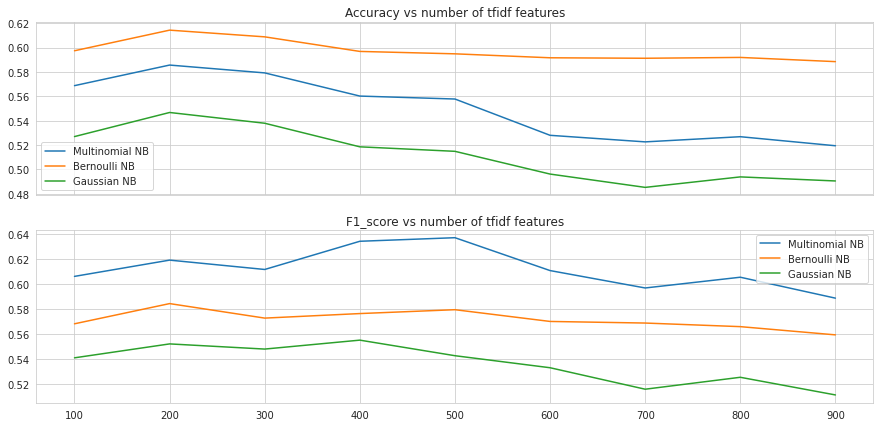

In [ ]:
from IPython.core.pylabtools import figsize
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set_style("whitegrid")
sns.set_color_codes(palette = "deep")

fig,ax = plt.subplots(2,1, sharex = True, figsize = (15,7))

ax[0].plot(num_of_features,mnb['acc'])
ax[0].plot(num_of_features,bnb['acc'])
ax[0].plot(num_of_features,gnb['acc'])
ax[0].legend(['Multinomial NB', 'Bernoulli NB', 'Gaussian NB'], )
ax[0].title.set_text("Accuracy vs number of tfidf features")

plt.title("Naive Bayes vs number of features ")


ax[1].plot(num_of_features,mnb['f1'])
ax[1].plot(num_of_features,bnb['f1'])
ax[1].plot(num_of_features,gnb['f1'])
ax[1].title.set_text("F1_score vs number of tfidf features")
ax[1].legend(['Multinomial NB', 'Bernoulli NB', 'Gaussian NB'])
#ax[1].title("Naive Bayes vs number of features")

SVM

In [ ]:
acc_svc = [];

svc_classifier = svm.SVC(decision_function_shape='ovo')
svc_classifier.fit(vec[:,:],int_labels_train)

svc_prediction = svc_classifier.predict(test_vec[:,:])
acc_svc.append(accuracy(svc_prediction, int_labels_val))

In [ ]:
plt.plot(acc_svc, num_of_features)

20NEWSGROUP

In [1]:
from utils import PrepareCorpus

/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parentdir = "Datasets"


train = parentdir+"/20news-bydate"+"/20news-bydate-train"
test =  parentdir+"/20news-bydate"+ "/20news-bydate-train"

In [3]:
news_group_train = PrepareCorpus(train)
news_group_test = PrepareCorpus(test)

In [4]:
news_group_train._corpus()
news_group_test._corpus()

news_group_train = news_group_train._corpus
news_group_test = news_group_test._corpus

In [10]:
news_group_train['talk.politics.mideast'][0]

'From: hm@cs.brown.edu (Harry Mamaysky)\n Subject: Heil Hernlem \n In-Reply-To: hernlem@chess.ncsu.edu\'s message of Wed, 14 Apr 1993 12:58:13 GMT\n Organization: Dept. of Computer Science, Brown University\n Lines: 24\n \n In article <1993Apr14.125813.21737@ncsu.edu> hernlem@chess.ncsu.edu (Brad Hernlem) writes:\n \n    Lebanese resistance forces detonated a bomb under an Israeli occupation\n    patrol in Lebanese territory two days ago. Three soldiers were killed and\n    two wounded. In "retaliation", Israeli and Israeli-backed forces wounded\n    8 civilians by bombarding several Lebanese villages. Ironically, the Israeli\n    government justifies its occupation in Lebanon by claiming that it is \n    necessary to prevent such bombardments of Israeli villages!!\n \n    Congratulations to the brave men of the Lebanese resistance! With every\n    Israeli son that you place in the grave you are underlining the moral\n    bankruptcy of Israel\'s occupation and drawing attention to the 

In [5]:
id2label = {x:i for i,x in enumerate(news_group_train.keys())}
id2label

{'talk.politics.mideast': 0,
 'rec.autos': 1,
 'comp.sys.mac.hardware': 2,
 'alt.atheism': 3,
 'rec.sport.baseball': 4,
 'comp.os.ms-windows.misc': 5,
 'rec.sport.hockey': 6,
 'sci.crypt': 7,
 'sci.med': 8,
 'talk.politics.misc': 9,
 'rec.motorcycles': 10,
 'comp.windows.x': 11,
 'comp.graphics': 12,
 'comp.sys.ibm.pc.hardware': 13,
 'sci.electronics': 14,
 'talk.politics.guns': 15,
 'sci.space': 16,
 'soc.religion.christian': 17,
 'misc.forsale': 18,
 'talk.religion.misc': 19}

In [6]:
#Converting input into a dictionary 

news_group_train_modif = {}
news_group_test_modif = {}

for key,value in news_group_train.items():
    list_of_strings = value
    lab = id2label[key]
    for text in list_of_strings:
        temp = news_group_train_modif.get('text', [])
        temp.append(text)
        news_group_train_modif['text'] = temp

        temp = news_group_train_modif.get('labels', [])
        temp.append(lab)
        news_group_train_modif['labels'] = temp

for key,value in news_group_test.items():
    list_of_strings = value
    lab = id2label[key]
    for text in list_of_strings:
        temp = news_group_test_modif.get('text', [])
        temp.append(text)
        news_group_test_modif['text'] = temp

        temp = news_group_test_modif.get('labels', [])
        temp.append(lab)
        news_group_test_modif['labels'] = temp

In [23]:
import json

train_file = "20news_train.json"
test_file = "20news_test.json"
id_2_label = "id2label.json"

with open(train_file, "w") as ins_1:
    json.dump(news_group_train_modif, ins_1)

with open(test_file, "w") as ins_2:
    json.dump(news_group_test_modif, ins_2)

with open(id_2_label, "w") as ins_3:
    json.dump(id_2_label, ins_3)

FileNotFoundError: [Errno 2] No such file or directory: '/refined/20news_train.json'

CLEANING FILES 

In [15]:
clean = [preproc(x) for x in news_group_train_modif['text']]
news_group_train_modif['text'] = clean

In [16]:
news_group_train_modif['text']

['Harry Mamaysky Subject Heil Hernlem Reply message d Apr 12:58:13 GMT Organization Dept Computer Science Brown University Lines article < > Brad Hernlem writes Lebanese resistance forces detonated bomb Israeli occupation patrol Lebanese territory days ago soldiers killed wounded retaliation Israeli Israeli backed forces wounded civilians bombarding Lebanese villages Ironically Israeli government justifies occupation Lebanon claiming necessary prevent bombardments Israeli villages Congratulations brave men Lebanese resistance Israeli son place grave underlining moral bankruptcy Israel occupation drawing attention Israeli government policy reckless disregard civilian life Brad Hernlem EDU nice people murdered Bradly overjoyed hear deaths middle east Jewish Arab deaths feel sadness hope soon stops Apparently view point acceptable people like Bradly Hernlem disgust Harry ',
 'Todd J. Dicker Subject Israel Expansion II Organization Cybernet BBS Boca Raton Florida Lines ab4z@Virginia EDU An

In [ ]:
clean = [preproc(x) for x in news_group_test_modif['text']]
news_group_test_modif['text'] = clean

In [83]:
train_news_vec, news_feat = extract_features(news_group_train_modif['text'], method = "Tfidf")
test_news_vec, news_feat = extract_features(news_group_test_modif['text'], method = "Tfidf")

/Users/max/Desktop/Dissertation/implementations/Disso-COLD/proj_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(11314, 224)
(11314, 224)


In [84]:
MNB.fit(train_news_vec, news_group_train_modif['labels'])
GNB.fit(train_news_vec.toarray(), news_group_train_modif['labels'])
BNB.fit(train_news_vec, news_group_train_modif['labels'])

BernoulliNB()

In [85]:
mnb_news_pred = MNB.predict(test_news_vec)
bnb_news_pred = BNB.predict(test_news_vec)
gnb_news_pred = GNB.predict(test_news_vec.toarray())

compute_metrics(mnb_news_pred, news_group_test_modif['labels']), compute_metrics(bnb_news_pred, news_group_test_modif['labels']), compute_metrics(gnb_news_pred, news_group_test_modif['labels'])

(50.866183489482054, 43.07053208414354, 39.28760827293619)